In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

from tqdm import tqdm

from mmsplice.generic import logit, expit
from mmsplice.utils import max_varEff
from mmsplice.utils.postproc import transform

projectDIR = '../../data/'

Using TensorFlow backend.


In [3]:
def get_start_end(s):
    # get start and end from exon string
    ssplit = s.split('_')
    start = int(ssplit[1])
    end, strand = ssplit[2].split(':')
    end = int(end)
    return start, end, strand

def get_var_pos(s):
    # get variant position from variant string
    ssplit = s.split(":")
    return int(ssplit[1])

def dinu_disrupt(x):
    exon_start, exon_end, strand = get_start_end(x['exons'])
    var_pos = get_var_pos(x['ID'])
    return ((var_pos - exon_end > 0) and (var_pos - exon_end < 3)) or ((exon_start - var_pos > 0) and (exon_start - var_pos < 3))

## Load predictions from MMSplice and other models

MMSplice, done with Snakefile from the Snakefile in this directory. 

In [4]:
predUniqMax = max_varEff(projectDIR + 'clinvar/mmsplice_pred.csv')

In [5]:
predUniqMax['dinu_disrupt'] =  predUniqMax.apply(dinu_disrupt, axis=1)

In [6]:
predUniqMax.shape

(69379, 14)

In [7]:
predUniqMax.head()

,ID,mmsplice_diff,exons,mmsplice_ref_acceptorIntron,mmsplice_ref_acceptor,mmsplice_ref_exon,mmsplice_ref_donor,mmsplice_ref_donorIntron,mmsplice_alt_acceptorIntron,mmsplice_alt_acceptor,mmsplice_alt_exon,mmsplice_alt_donor,mmsplice_alt_donorIntron,dinu_disrupt
0,10:100177926:C:['T'],-0.359619,10_100177932_100178014:-,-4.054594,5.272730,-2.743317,2.674313,-0.163427,-4.054594,5.272730,-2.743317,2.194031,-0.163427,False
1,10:100179910:C:['T'],0.087183,10_100179802_100179915:-,-3.862209,5.427852,-2.754818,3.642254,0.182360,-3.862209,5.427852,-2.698903,3.642254,0.182360,False
2,10:100179917:T:['G'],-2.958933,10_100179802_100179915:-,-3.862209,5.427852,-2.754818,3.642254,0.182360,-3.862209,1.335677,-2.754818,3.642254,0.182360,True
3,10:100182277:G:['T'],-0.691924,10_100182126_100182270:-,-3.915008,-3.626794,-3.049119,3.016737,0.397928,-4.197525,-4.045979,-3.049119,3.016737,0.397928,False
4,10:100182285:T:['C'],-0.129285,10_100182126_100182270:-,-3.915008,-3.626794,-3.049119,3.016737,0.397928,-3.933263,-3.771658,-3.049119,3.016737,0.397928,False


kipoi models

In [8]:
import pickle
def read_pkl(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)

In [9]:
clinvar_file = projectDIR + "clinvar/clinvar_ext_Xy.pkl"
X_clinvar, y_clinvar = read_pkl(clinvar_file)

In [10]:
X_clinvar.shape

(11663, 44)

In [11]:
X_clinvar['early_stop'] = X_clinvar.early_stop.astype(bool)
y_clinvar = y_clinvar[~X_clinvar['early_stop']]
X_clinvar = X_clinvar[~X_clinvar['early_stop']]

In [12]:
X_clinvar = X_clinvar.merge(predUniqMax, how='left', left_on='variant_id', right_on='ID')

In [13]:
sum(X_clinvar['mmsplice_diff'].isna().astype(int))

0

In [14]:
sum(X_clinvar['HAL_isna'])

4127.0

### Modeling

In [15]:
# Scikit-learn imports
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn_pandas import DataFrameMapper

/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [16]:
class ZeroImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return pd.DataFrame(X).fillna(0).copy()

In [17]:
def preproc(features):
    """Pre-processing pipeline
    """
    return DataFrameMapper([
            (features, [ZeroImputer(), 
                        sklearn.preprocessing.StandardScaler(),
                       ]),
        ])

In [18]:
# model = LogisticRegressionCV(penalty="l1", solver='liblinear', scoring="roc_auc", cv=3, n_jobs=1)
# LogReg is completely fine here as D < 20 < 1000 < N
model=LogisticRegressionCV(penalty="l1", solver='liblinear', scoring="roc_auc", cv=3, n_jobs=1)
np.random.seed(42)

In [19]:
def evaluate(df, y, features, model, model_name):
    perm = np.random.permutation(len(df))  # permute rows
    ret = cross_validate(Pipeline([('preproc', preproc(features)), 
                                   ('model', model)]), 
                         df.iloc[perm], y[perm], scoring=['accuracy', 'roc_auc'], cv=10, n_jobs=10, return_train_score=True)
    means = pd.DataFrame(ret).describe().loc['mean']
    means.index = "mean_" + means.index
    sds = pd.DataFrame(ret).describe().loc['std']
    sds.index = "std_" + sds.index
    return pd.DataFrame([{**dict(means), **dict(sds), "model_name": model_name}])

In [20]:
from sklearn.utils import resample
def roc(df, y, features, model, bootstrap=999):
    perm = np.random.permutation(len(df))  # permute rows
    pred = cross_val_predict(Pipeline([('preproc', preproc(features)), 
                                   ('model', model)]), 
                         df.iloc[perm], y[perm], cv=10, n_jobs=10, method='predict_proba')
    print(roc_auc_score(y[perm], pred[:,1]))
    aucs = []
    ## Boostrap here
    n = 0
    while n < bootstrap:
#         import pdb
#         pdb.set_trace()
        boot = resample(y[perm], pred[:,1])
        aucs.append(roc_auc_score(boot[0], boot[1]))
        n += 1
    return np.array(aucs)
    #fpr, tpr, _ = roc_curve(y[perm], pred[:,1])
    #return fpr, tpr

## Plus conservation

In [21]:
ref_list = ['mmsplice_ref_acceptorIntron', 'mmsplice_ref_acceptor', 'mmsplice_ref_exon', 'mmsplice_ref_donor', 'mmsplice_ref_donorIntron']
alt_list = ['mmsplice_alt_acceptorIntron', 'mmsplice_alt_acceptor', 'mmsplice_alt_exon', 'mmsplice_alt_donor', 'mmsplice_alt_donorIntron']
X = X_clinvar[alt_list].values - X_clinvar[ref_list].values

X_clinvar['mmsplice_exon_overlap'] = np.logical_or(np.logical_and(X[:,1]!=0, X[:,2]!=0), np.logical_and(X[:,2]!=0, X[:,3]!=0))
X_clinvar['mmsplice_acceptor_intron_overlap'] = np.logical_and(X[:,0]!=0, X[:,1]!=0)
X_clinvar['mmsplice_donor_intron_overlap'] = np.logical_and(X[:,3]!=0, X[:,4]!=0)

MMSplice_features = [x for x in X_clinvar.columns[X_clinvar.columns.str.startswith('mmsplice')]]
MaxEntScan_features = [x for x in X_clinvar.columns[X_clinvar.columns.str.startswith('MaxEntScan')]]
HAL_features = [x for x in X_clinvar.columns[X_clinvar.columns.str.startswith('HAL')]]
spidex_feat = ['dpsi_max_tissue', 'dpsi_zscore', 'dpsi_max_tissue_isna', 'dpsi_zscore_isna']
# MMSplice_features.remove("mmsplice_diff")

In [22]:
dbscsnv_dbscsnv_feat = ['dbscSNV_rf_score', 'dbscSNV_rf_score_isna']

In [23]:
conservation_features = ['phyloP46way_placental', 'phyloP46way_primate', 'CADD_raw', 'CADD_phred']

In [24]:
kipoi_features = ['MaxEntScan/3prime_alt',
                  'MaxEntScan/3prime_ref',
                  'MaxEntScan/3prime_isna',
                  'MaxEntScan/5prime_alt',
                  'MaxEntScan/5prime_ref',
                  'MaxEntScan/5prime_isna',
                  'HAL_ref',
                  'HAL_alt',
                  'HAL_isna',
                  'labranchor_logit_alt',
                  'labranchor_logit_ref',
                  'labranchor_isna']

In [25]:
clinvar_kipoi_features = kipoi_features + conservation_features

## Plot ROC curve

In [26]:
feature_group = [MMSplice_features, MMSplice_features+conservation_features, spidex_feat, kipoi_features, kipoi_features+MMSplice_features, clinvar_kipoi_features + MMSplice_features]
model_names = ["MMSplice", "MMSplice + conservation", "SPANR", "kipoiSplice4", "kipoiSplice5", "kipoiSplice5_conservation"]

In [27]:
stats = []
for i, feat in enumerate(feature_group):
    print(model_names[i])
    stats.append(roc(X_clinvar, y_clinvar, feat, model, bootstrap=999))

MMSplice
0.9391301845079518
MMSplice + conservation
0.9725761138023892
SPANR
0.8203990027180611
kipoiSplice4
0.927360638663383
kipoiSplice5
0.953609192838422
kipoiSplice5_conservation
0.978603013791776


In [28]:
stats = np.stack(stats)

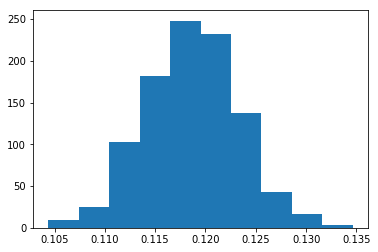

In [29]:
## compare with SPANR
(1 + sum(stats[0,:] < stats[2,:])) / 1000
plt.hist(stats[0,:] - stats[2,:])
plt.show()

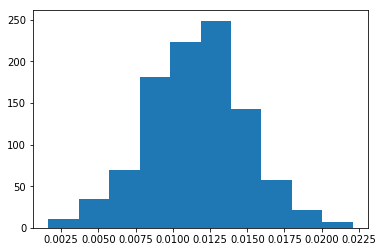

In [30]:
## compare with ensemble of MaxEntScan, HAL and labranchor
(1 + sum(stats[0,:] < stats[3,:])) / 1000
plt.hist(stats[0,:] - stats[3,:])
plt.show()

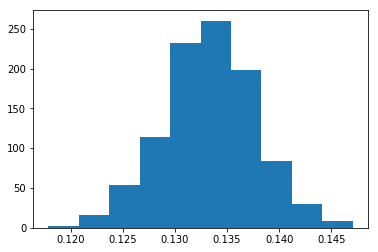

In [31]:
## compare ensemble of MaxEntScan, HAL and labranchor to ensemble with/w.o MMSplice
(1 + sum(stats[4,:] < stats[3,:])) / 1000
plt.hist(stats[4,:] - stats[2,:])
plt.show()

0.002


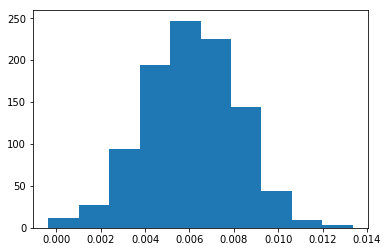

In [32]:
## compare MMSplice + conservation with ensemble of MaxEntScan, HAL, labranchor and MMSplice + conservation
print((1 + sum(stats[5,:] < stats[1,:])) / 1000)
plt.hist(stats[5,:] - stats[1,:])
plt.show()

## Cumulate performance

In [33]:
def run_model_groups(df, y, model_groups,
                     model=LogisticRegressionCV(penalty="l1", solver='liblinear', scoring="roc_auc", cv=3, n_jobs=1)):
    res = []
    use_features = []
    for mg in tqdm(model_groups):
        use_features += [f for f in df.columns if f.startswith(mg)]
        if mg=='labranchor':
            mg = 'labranchor (KipoiSplice4)'
        elif mg=='MMSplice':
            mg = 'MMSplice (KipoiSplice5)'
        res.append(evaluate(df, y, use_features, model, model_name=mg))
    return pd.concat(res)

In [34]:
models = ["MaxEntScan/3prime", "MaxEntScan/5prime", "HAL", "labranchor" ,"mmsplice"]

In [35]:
res_clinvar = run_model_groups(X_clinvar, y_clinvar, models, model=model)

100%|██████████| 5/5 [01:18<00:00, 15.70s/it]


In [36]:
res_clinvar

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_roc_auc,mean_train_accuracy,mean_train_roc_auc,model_name,std_fit_time,std_score_time,std_test_accuracy,std_test_roc_auc,std_train_accuracy,std_train_roc_auc
0,3.159491,0.026368,0.745592,0.779734,0.745642,0.779730,MaxEntScan/3prime,0.350036,0.018622,0.012685,0.009475,0.001476,0.000974
0,3.521396,0.028753,0.832474,0.896028,0.832810,0.896443,MaxEntScan/5prime,0.331880,0.016654,0.013516,0.009632,0.001699,0.001109
0,5.181367,0.074637,0.834157,0.906214,0.834469,0.906798,HAL,0.620320,0.043730,0.010730,0.008280,0.001216,0.000903
0,6.036655,0.071322,0.842744,0.927893,0.843190,0.928425,labranchor (KipoiSplice4),0.537341,0.040516,0.010847,0.004031,0.001151,0.000453
0,37.988574,0.073585,0.872144,0.953564,0.873853,0.954744,mmsplice,7.095836,0.027216,0.014400,0.004536,0.002229,0.000536


In [37]:
MMSplice_features

['mmsplice_diff',
 'mmsplice_ref_acceptorIntron',
 'mmsplice_ref_acceptor',
 'mmsplice_ref_exon',
 'mmsplice_ref_donor',
 'mmsplice_ref_donorIntron',
 'mmsplice_alt_acceptorIntron',
 'mmsplice_alt_acceptor',
 'mmsplice_alt_exon',
 'mmsplice_alt_donor',
 'mmsplice_alt_donorIntron',
 'mmsplice_exon_overlap',
 'mmsplice_acceptor_intron_overlap',
 'mmsplice_donor_intron_overlap']

In [38]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, clinvar_kipoi_features + spidex_feat + MMSplice_features, 
                                          model=model,
                                          model_name="KipoiSplice5 w/ cons."))

In [39]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, spidex_feat,
                                          model=model,
                                          model_name="SPANR"))

In [40]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, spidex_feat + conservation_features,
                                          model=model,
                                          model_name="SPANR w/ cons."))

In [41]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, MMSplice_features,
                                          model=model,
                                          model_name="MMSplice"))

In [42]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, MMSplice_features + conservation_features,
                                          model=model,
                                          model_name="MMSplice w/ cons."))

In [43]:
res_clinvar

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_roc_auc,mean_train_accuracy,mean_train_roc_auc,model_name,std_fit_time,std_score_time,std_test_accuracy,std_test_roc_auc,std_train_accuracy,std_train_roc_auc
0,3.159491,0.026368,0.745592,0.779734,0.745642,0.779730,MaxEntScan/3prime,0.350036,0.018622,0.012685,0.009475,0.001476,0.000974
0,3.521396,0.028753,0.832474,0.896028,0.832810,0.896443,MaxEntScan/5prime,0.331880,0.016654,0.013516,0.009632,0.001699,0.001109
0,5.181367,0.074637,0.834157,0.906214,0.834469,0.906798,HAL,0.620320,0.043730,0.010730,0.008280,0.001216,0.000903
0,6.036655,0.071322,0.842744,0.927893,0.843190,0.928425,labranchor (KipoiSplice4),0.537341,0.040516,0.010847,0.004031,0.001151,0.000453
0,37.988574,0.073585,0.872144,0.953564,0.873853,0.954744,mmsplice,7.095836,0.027216,0.014400,0.004536,0.002229,0.000536
0,26.124957,0.137398,0.944003,0.978704,0.944657,0.979723,KipoiSplice5 w/ cons.,3.903458,0.052763,0.007184,0.005602,0.000940,0.000594
0,2.666498,0.048773,0.754084,0.820490,0.754353,0.820813,SPANR,0.538807,0.035998,0.012646,0.012347,0.001598,0.001387
0,4.492783,0.045935,0.852822,0.920389,0.853549,0.920716,SPANR w/ cons.,0.496884,0.025525,0.007306,0.004797,0.000658,0.000493
0,30.575840,0.056467,0.839757,0.938853,0.842142,0.940133,MMSplice,6.843838,0.030113,0.010673,0.006326,0.001487,0.000754
0,22.127516,0.085036,0.930751,0.972510,0.931716,0.973183,MMSplice w/ cons.,3.945723,0.053475,0.007183,0.003721,0.000767,0.000446


## Plot

In [44]:
cm = plt.get_cmap('tab10')

In [45]:
kipoi_model_names = [
    'MaxEntScan/3prime',
     '+MaxEntScan/5prime',
     '+HAL',
     '+labranchor',
     '+MMSplice',
     '+conservation (KipoiSplice5)']

In [46]:
res_clinvar.model_name

0            MaxEntScan/3prime
0            MaxEntScan/5prime
0                          HAL
0    labranchor (KipoiSplice4)
0                     mmsplice
0        KipoiSplice5 w/ cons.
0                        SPANR
0               SPANR w/ cons.
0                     MMSplice
0            MMSplice w/ cons.
Name: model_name, dtype: object

In [47]:
other_model_names = list(res_clinvar.model_name[6:])

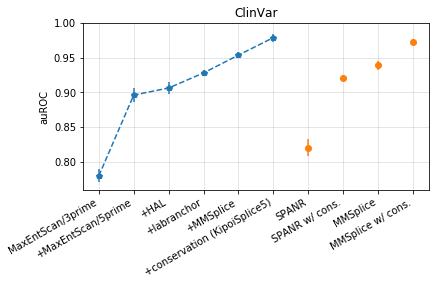

In [48]:
fig=plt.figure(figsize=(6, 4))
fig.subplots_adjust(bottom=0.3, left=0.1)
plt.subplot(111)
col1 = cm.colors[0]
col2 = cm.colors[1]
tilt = 30
plt.errorbar(kipoi_model_names, res_clinvar.mean_test_roc_auc[:6], yerr=res_clinvar.std_test_roc_auc[:6], fmt='p--', color=col1)
#plt.errorbar(res_clinvar.model_name[4:5], res_clinvar.mean_test_roc_auc[4:5], yerr=res_clinvar.std_test_roc_auc[4:5], fmt='o', color=col1)
plt.errorbar(other_model_names, res_clinvar.mean_test_roc_auc[6:], yerr=res_clinvar.std_test_roc_auc[6:], fmt='o', color=col2)
plt.title("ClinVar")
plt.grid(alpha=0.4)
plt.ylim((None, 1))
plt.ylabel("auROC")
plt.xticks(rotation=tilt, horizontalalignment="right");
#plt.tight_layout(h_pad=0);
# plt.savefig('clinvar_20180429.pdf', dpi=600)
plt.close(fig)    # close the figure
fig